In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy
from IPython import display
import seaborn as sns
from scipy import signal
import parkinson_modules as pm
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import matplotlib
from scipy.spatial import transform
# matplotlib.rcParams['text.usetex'] = True
from scipy.signal import butter, welch, filtfilt
warnings.filterwarnings('ignore')
# %matplotlib nbagg
%matplotlib inline

def ewma_filter(data, N = 10):
    swertka = np.zeros(N*10)
    alpha = 2/(N+1)
    data_filt = data.copy()
    swertka[0] = 1
    for i in range(1, N*10):
        swertka[i] = swertka[i-1]*(1 - alpha)
    for i in range(len(data)):
        r_sw = min(len(data) - i , N*10)
        r_data = min(len(data), i + N*10)
    #     print(r_data - i, r_sw)
        data_filt[i] = (data[i:r_data]*swertka[:r_sw]).sum()/swertka[:r_sw].sum()
    return data_filt

def v_(q):
    v = np.array([2*(q[1]*q[3] -  q[0]* q[2]),
    2*( q[0]* q[1] +  q[2]* q[3]),
     q[0]**2 -  q[1]**2 -  q[2]**2 +  q[3]**2])
    return v

def moving_average(arr, N = 200):
    m_a = np.zeros(arr.shape)
    for i in range(arr.shape[0]):
        right = min(i+N, arr.shape[0])
        m_a[i] = arr[i] - arr[i:i+N].mean(axis = 0)
    return m_a

def quaternion_multiply(quaternion1, quaternion0):
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

def q_conjugate(q):
    w, x, y, z = q
    return np.array([w, -x, -y, -z])


In [2]:
import ahrs2 as ahrs
import quaternion as Quaternion
import ahrs as ah

In [3]:
file = pd.read_csv('C:/Files/parkinson/PatientDataV2/patient58/58/ex1_58.csv')

ax, ay, az = file['acc_y, mg'].values[2:], file['acc_z, mg'].values[2:], file['acc_x, mg'].values[2:]
gx, gy, gz = file['gyr_y, dps'].values[2:], file['gyr_z, dps'].values[2:], file['gyr_x, dps'].values[2:]
mx, my, mz = file['mag_y, mga'].values[2:], file['mag_z, mga'].values[2:], file['mag_x, mga'].values[2:]
time = file['time, s'].values[2:]

In [4]:
def reconstruction(ax,ay,az,gx,gy,gz,time):
    Q = np.tile([1., 0., 0., 0.], (len(ax), 1)) # Allocate an array for all quaternions

    filtCutOff = 0.001
    b, a = butter(1, (2*filtCutOff)/(100), 'highpass')
    acc_mag = np.sqrt(ax*ax + ay*ay + az*az)/1000
    acc_magFilt = filtfilt(b, a, acc_mag)
    acc_magFilt = np.abs(acc_magFilt)
    filtCutOff = 5
    [b, a] = butter(1, (2*filtCutOff)/(100), 'lowpass')
    acc_magFilt = filtfilt(b, a, acc_magFilt)
    stationary = acc_magFilt < 0.05
    ahrs_imu = ahrs.MahonyAHRS(kp=1, ki = 1)
    # ahrs_imu.reset()
    d2g = np.pi/180
    for i in range(2000):
        ahrs_imu.update_imu([0, 0, 0], np.array([ax.mean(), ay.mean(), az.mean()]), 0.01);

    for t in range(1, len(ax)):
        if stationary[t]:
            ahrs_imu.kp = 0.5
        else:
            ahrs_imu.kp = 0
        ahrs_imu.update_imu(d2g*np.array([gx[t], gy[t], gz[t]]),
                            np.array([ax[t], ay[t], az[t]]),
                            time[t] - time[t-1])

        Q[t] = ahrs_imu.quaternion
    a_rotate = np.zeros((len(ax), 3))

    for i in range(len(ax)):
        RQ = ah.common.orientation.q2R(q_conjugate(Q[i]))
        a_rotate[i] = RQ@np.array([ax[i], ay[i], az[i]])
    a_rotate = a_rotate - a_rotate.mean()
    a_rotate = moving_average(a_rotate)
    vel = np.zeros((len(ax), 3))
    for t in range(1, len(ax)):
        vel[t] = vel[t-1] + 0.0098*a_rotate[t] * (time[t] - time[t-1]);
        if (stationary[t] == 1):
            vel[t] = np.array([0, 0, 0]) #  force zero velocity when foot stationary
    diff_stationary = np.array(stationary[1:], dtype = np.int) - np.array(stationary[:-1], dtype = np.int)
    stationaryStart = np.argwhere(diff_stationary == -1)[:, 0]
    stationaryEnd = np.argwhere(diff_stationary == 1)[:,0]
    velDrift = np.zeros(vel.shape)

    if stationary[0] == False:
        stationaryEnd = stationaryEnd[1:]
    NNN = min(len(stationaryEnd), len(stationaryStart))
    for i in range(NNN):
        driftRate = vel[stationaryEnd[i]-1] / (stationaryEnd[i] - stationaryStart[i])
        enum = np.arange(1, stationaryEnd[i] - stationaryStart[i])
        drift = np.array([enum*driftRate[0],enum*driftRate[1], enum*driftRate[2]]).T
        velDrift[stationaryStart[i]:stationaryEnd[i]-1] = drift
    vel = vel - velDrift
    pos = np.zeros(vel.shape)
    for t in range(1, len(ax)):
        pos[t] = pos[t-1] + vel[t] * (time[t] - time[t-1])
    return pos

In [5]:
done = []

In [36]:
os.chdir('C:\Files\parkinson')
info = pd.read_excel('Info.xlsx')
info = info.fillna(value = -1)
os.chdir('C:/Files/parkinson/PatientDataV2/')
path = 'C:/Files/parkinson/PatientDataV2/'
trajectory_dct = {}
file = pd.DataFrame()
list_files = os.listdir()
count = 0
for name in list_files:
    if '.' in name:
        continue
    index = [int(name[7:])]
#     print(name)
    patient_info = info[info['ID'] == index[0]]
    folders = os.listdir(path + name)
    
    for fold in folders:
        trajectory_dct[fold] = {}
        if '.' in fold:
            continue
        if fold in done:
            continue
        print(fold)
        index = list(map(int, fold.split('_')))
        if len(index) == 1:
            index.append(1)
        patient = pm.parkinson(path + name + '/' + fold)
        patient.read(filtering = False)
        for exer_keys in patient.exercises:
#             print(exer_keys)
            exers = patient.exercises[exer_keys]
            ax, ay, az = exers['acc_x, mg' ].values[2:], exers['acc_y, mg' ].values[2:], exers['acc_z, mg' ].values[2:]
            gx, gy, gz = exers['gyr_x, dps'].values[2:], exers['gyr_y, dps'].values[2:], exers['gyr_z, dps'].values[2:]
            timing = patient.time[exer_keys].values[2:]
            
            ax, ay, az = ewma_filter(ax), ewma_filter(ay), ewma_filter(az)
            gx, gy, gz = ewma_filter(gx), ewma_filter(gy), ewma_filter(gz)
            
            Acc_mag = np.sqrt(ax**2 + ay**2 + az**2)
            index = np.argwhere(Acc_mag > 0.0001)
            
            xyz = reconstruction(ax[index][:,0], ay[index][:,0], az[index][:,0], 
                                gx[index][:,0], gy[index][:,0], gz[index][:,0], 
                                timing[index][:,0])

#             xyz = reconstruction(ax, ay, az, 
#                                  gx, gy, gz, 
#                                  timing)
            trajectory_dct[fold][exer_keys] = xyz
        done.append(fold)
#             break
#         break
#     break


01
01_2
02
02_2
03
03_2
04
04_2
05
05_2
06
06_2
07
07_2
08
08_2
09
09_2
10
10_2
11
11_2
12
12_2
13
13_2
14
14_2
15
15_2
16
16_2
17
17_02
18
18_02
19
19_02
20
20_2
21
22
22_2
23
23_2
24
24_2
25
25_2
26
27
28
28_2
29
broken_ex14_29.csv 
 !!ERROR!!
30
31
32
broken_ex13_32.csv 
 !!ERROR!!
32_2
33
33_2
34
35
36
37
38
39
40
41
41_2
42
42_2
43
43_2
44
45_2
46
47
48
49
50
51
52
53
53_2
54
54_2
55
55_2
56
56_2
57
57_2
58
59
60
62
63
63_2
64
65
66
67
68
69


In [13]:
# import pickle

# Step 2
# with open('C:/Files/parkinson/trajectory_per_person.pkl', 'wb') as config_dictionary_file:
 
#   # Step 3
#     pickle.dump(trajectory_dct, config_dictionary_file)

In [5]:
import pickle

with open('C:/Files/parkinson/trajectory_per_person.pkl', 'rb') as config_dictionary_file:
    trajectory_dct = pickle.load( config_dictionary_file)

In [6]:
def rot_matrix(vec0, vec2):
    '''
    rotate 3d vector (vec) to [1 0 0] direction
    e2 is 
    '''
    if np.linalg.norm(vec0) < 0.001:
        vec0 = np.random.random(3)
    e3= vec2/np.linalg.norm(vec2)
    
    R = np.zeros((3,3))
    R[2] = e3
    R[0] = vec0 - np.sum(e3*vec0)*e3
    R[0] = R[0]/np.linalg.norm(R[0])
    e2 = np.cross(R[0], R[2])
    R[1] = e2/np.linalg.norm(e2)
    R = np.linalg.inv(R.T)
    return R

In [7]:
def euclid_algo(n, m):  #  where n > m
    if n < m:
        return(euclid_algo(m, n))
    r = n % m
    if r == 0:
        return m
    else:
        return euclid_algo(m, r)
    
def up_down_factor(l, new_size):
    m = euclid_algo(l,new_size)
    up = new_size//2
    down = l//2
    return up, down

In [8]:
def correlation_function(sig1, sig2):
    if len(sig1) > len(sig2):
        return correlation_function(sig2, sig1)
    return scipy.signal.correlate(sig2, sig1, mode= 'same')

In [10]:
# sig1 = trajectory_dct_rotate['01'][12]
# sig2 = trajectory_dct_rotate['02'][12]
# corr = correlation_function(sig1, sig2)

In [11]:
trajectory_dct_rotate = {}
for person in trajectory_dct:
    trajectory_dct_rotate[person] = {}
    for exer in trajectory_dct[person]:
        pos = trajectory_dct[person][exer]
        R = rot_matrix(pos.mean(axis = 0), np.array([0,0,1]))
        pos_rotate = (R@pos.T).T
        coef = pos_rotate.mean(axis = 0)
        pos_rotate = pos_rotate - coef
        coef = (pos_rotate.std(axis = 0) + 0.001)
        up, down = up_down_factor(len(pos_rotate), 4000)
        trajectory_dct_rotate[person][exer] =  scipy.signal.resample_poly(pos_rotate/coef, up, down)[:4000]
        pos_rotate = trajectory_dct_rotate[person][exer]
        mean_half = np.sign(pos_rotate[:len(pos_rotate)//2].mean(axis = 0)) + 1.e-3
        trajectory_dct_rotate[person][exer] = trajectory_dct_rotate[person][exer]*mean_half
        coef = trajectory_dct_rotate[person][exer][0]

        trajectory_dct_rotate[person][exer] = trajectory_dct_rotate[person][exer] - coef
        
        #         break
#     break

In [21]:
import pywt

In [311]:
cA = np.zeros(2000)
cD = np.zeros(2000)
total_signal = np.zeros(4000)
count = 0
for person in trajectory_dct_rotate:
    if 12 not in trajectory_dct_rotate[person]:
        continue
    ca_, cd_ = pywt.dwt(trajectory_dct_rotate[person][12][:,2],'db1')
    total_signal += trajectory_dct_rotate[person][12][:,2]
    cA += (ca_)
    cD += np.abs(cd_)
    count +=1
total_signal /= count
cA /= count
cD /= count

In [312]:
signal = pywt.idwt(cA, cD, 'db1', 'symmetric')

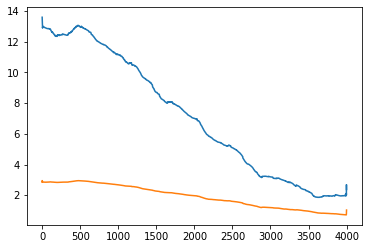

In [313]:
plt.plot(signal)
plt.plot(total_signal)

In [286]:
cA, cD = pywt.dwt(np.random.random(4000), 'db1')

In [289]:
cA.shape, cD.shape

((2000,), (2000,))

In [22]:

for person in trajectory_dct:
    for exer in trajectory_dct[person]:
        if exer not in bad_per_exer:
            bad_per_exer[exer] = []
        bad_per_exer[exer].append(len(trajectory_dct[person][exer]))

NameError: name 'bad_per_exer' is not defined

In [23]:
bad_per_exer

NameError: name 'bad_per_exer' is not defined

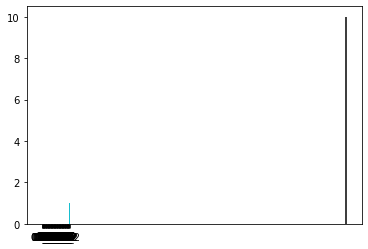

In [247]:
plt.hist(bad_per_exer[12], bins = 50)
plt.vlines(len(trajectory_dct['01'][12]), ymin = 0, ymax = 10)

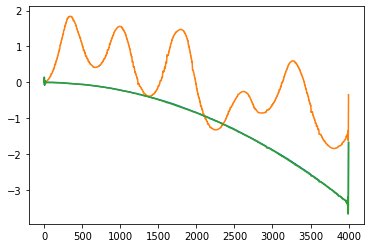

In [28]:
plt.plot(trajectory_dct_rotate['01'][12])

In [30]:
bad_per_exer = {}
for person in trajectory_dct_rotate:
    for exer in trajectory_dct_rotate[person]:
        if exer not in bad_per_exer:
            bad_per_exer[exer] = []
        arr = trajectory_dct_rotate[person][exer]
        if arr.max()> 200:
            bad_per_exer[exer].append(person)
for exer in  bad_per_exer:
    print(exer, len(bad_per_exer[exer]))

10 0
11 0
12 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
13 0
14 0
15 0


In [31]:
# for person in trajectory_dct:
#     if 14 in trajectory_dct[person]:
#         print(person, trajectory_dct[person][14][0][0], len(trajectory_dct[person][14]), trajectory_dct[person][14].mean(), trajectory_dct[person][14].std())

In [32]:
for person in trajectory_dct_rotate:
    if 14 in trajectory_dct_rotate[person]:
        print(person, trajectory_dct_rotate[person][14][0][0], len(trajectory_dct_rotate[person][14]))

25 0.0 4000
25_2 0.0 4000
26 0.0 4000
27 0.0 4000
28 0.0 4000
28_2 0.0 4000
29 0.0 4000
30 0.0 4000
31 0.0 4000
32 0.0 4000
32_2 0.0 4000
33 0.0 4000
33_2 0.0 4000
34 0.0 4000
35 0.0 4000
36 0.0 4000
37 0.0 4000
38 0.0 4000
39 0.0 4000
40 0.0 4000
41 0.0 4000
41_2 0.0 4000
42 0.0 4000
42_2 0.0 4000
43 0.0 4000
43_2 0.0 4000
45_2 0.0 4000
46 0.0 4000
47 0.0 4000
48 0.0 4000
49 0.0 4000
50 0.0 4000
51 0.0 4000
52 0.0 4000
53 0.0 4000
53_2 0.0 4000
54 0.0 4000
54_2 0.0 4000
55 0.0 4000
55_2 0.0 4000
56 0.0 4000
56_2 0.0 4000
57 0.0 4000
57_2 0.0 4000
58 0.0 4000
59 0.0 4000
60 0.0 4000
62 0.0 4000
63 0.0 4000
63_2 0.0 4000
64 0.0 4000
65 0.0 4000
66 0.0 4000
67 0.0 4000
68 0.0 4000
69 0.0 4000


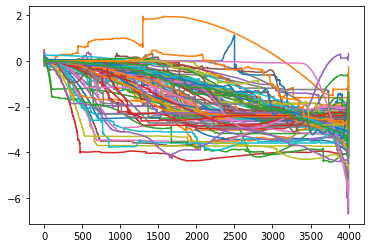

In [33]:
exer_index = 1
for key in trajectory_dct_rotate:
    if exer_index in trajectory_dct_rotate[key]:
        plt.plot(trajectory_dct_rotate[key][exer_index][:,0])
#         print(trajectory_dct_rotate[key][12][-1])

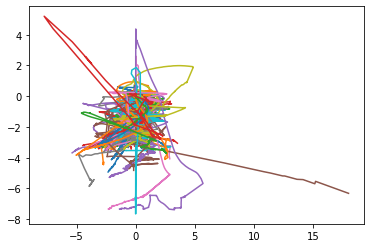

In [34]:
exer_index = 10
for key in trajectory_dct_rotate:
    if exer_index in trajectory_dct_rotate[key]:
        plt.plot(trajectory_dct_rotate[key][exer_index][:,1], trajectory_dct_rotate[key][exer_index][:,0])
#         print(trajectory_dct_rotate[key][12][-1])

In [35]:
pos_rotate.mean(axis = 0)

array([-0.00038903, -0.00016747,  0.00041616])

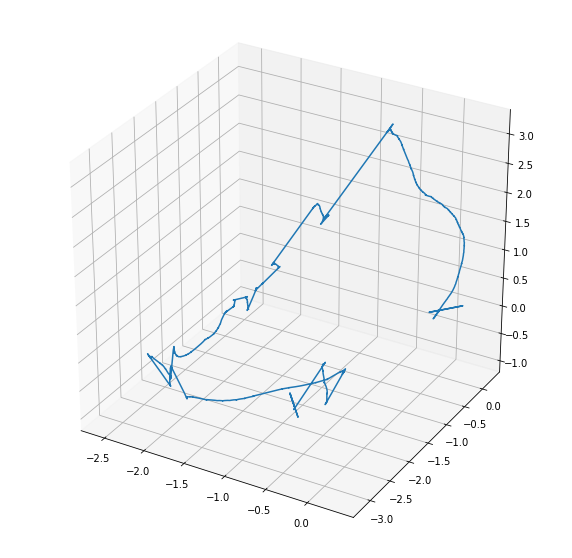

In [36]:
fig = plt.figure(figsize= (10, 10))
start = 0
end = -1
axes = fig.add_subplot(111, projection='3d')
pos = trajectory_dct_rotate['02'][1]
axes.plot(pos[start:end,2], pos[start:end,0], pos[start:end,1])
plt.show()

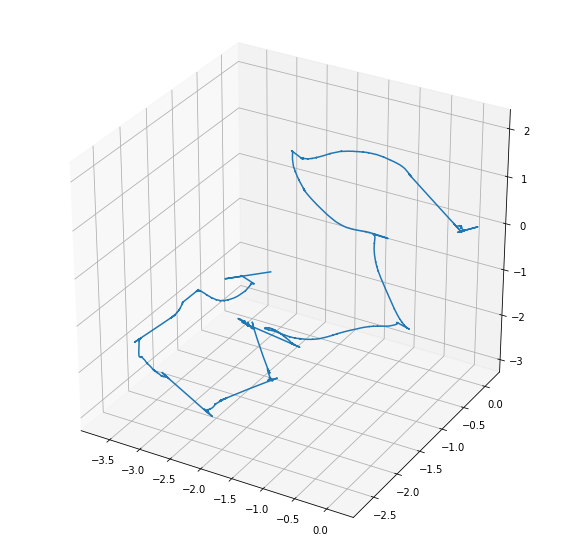

In [37]:
fig = plt.figure(figsize= (10, 10))
start = 0
end = -1
axes = fig.add_subplot(111, projection='3d')
pos = trajectory_dct_rotate['40'][1]
axes.plot(pos[start:end,2], pos[start:end,0], pos[start:end,1])
plt.show()

In [38]:
lll = []
for person in trajectory_dct_rotate:
    for exer in trajectory_dct_rotate[person]:
        lll.append(len(trajectory_dct_rotate[person][exer]))

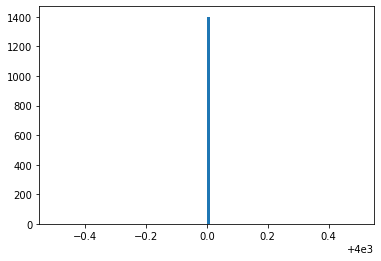

In [39]:
plt.hist(lll, bins = 100)
plt.show()

In [40]:
mean_per_exercise = {}
std_per_exercise = {}
number_per_exercise = {}

In [41]:
for person in trajectory_dct_rotate:
    for exer in trajectory_dct_rotate[person]:
        if person in bad_per_exer[exer]:
            continue
        if exer not in mean_per_exercise:
            mean_per_exercise[exer] = np.zeros((4000,3))
            number_per_exercise[exer] = 0
        number_per_exercise[exer] += 1
        mean_per_exercise[exer] += trajectory_dct_rotate[person][exer]
        
for exer in number_per_exercise:
    mean_per_exercise[exer] = mean_per_exercise[exer]/number_per_exercise[exer]

In [42]:
for person in trajectory_dct_rotate:
    for exer in trajectory_dct_rotate[person]:
        if person in bad_per_exer[exer]:
            continue
        if exer not in std_per_exercise:
            std_per_exercise[exer] = np.zeros((4000,3))
            number_per_exercise[exer] = 0
        number_per_exercise[exer] += 1
        std_per_exercise[exer] += (trajectory_dct_rotate[person][exer] - mean_per_exercise[exer])**2
        
for exer in number_per_exercise:
    std_per_exercise[exer] = np.sqrt(std_per_exercise[exer])/number_per_exercise[exer]

In [43]:
std_per_exercise[14]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.28439323e-02, 9.54482304e-05, 4.15979097e-02],
       [2.87326546e-02, 1.80948044e-04, 2.79439869e-02],
       ...,
       [2.36125240e-01, 2.66189653e-01, 2.41384443e-01],
       [2.30971074e-01, 2.57077520e-01, 2.35923472e-01],
       [2.42934202e-01, 2.80802309e-01, 2.49217221e-01]])

In [44]:
pos = trajectory_dct_rotate['12'][12]
pos2 = trajectory_dct_rotate['16'][12]

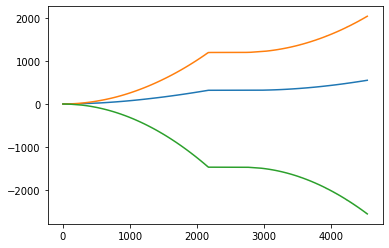

In [45]:
plt.plot(trajectory_dct['01'][10])

In [46]:
summa= 0
for exer in  bad_per_exer:
    summa += len(bad_per_exer[exer])

In [47]:
print(summa/15)

0.0


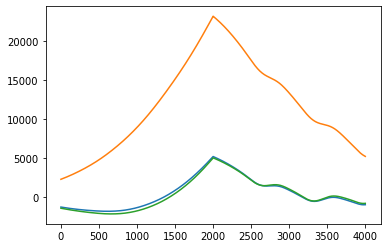

In [48]:
corr= scipy.signal.correlate(pos2, pos, mode = 'same')
plt.plot(corr)

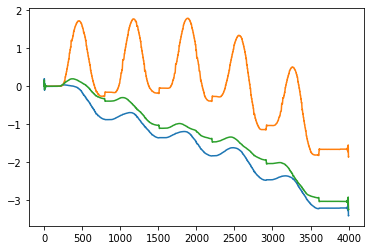

In [49]:
plt.plot(pos)

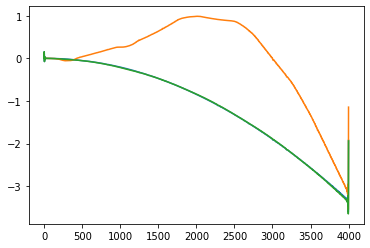

In [50]:
plt.plot(pos2)

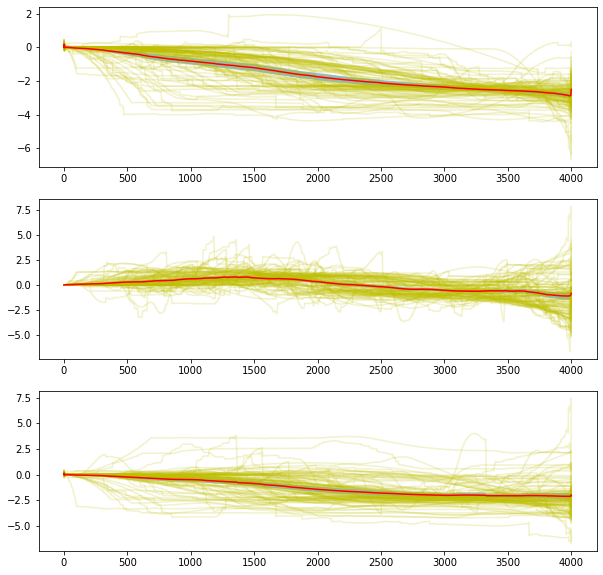

In [51]:
exer = 1
f, (ax,ay,az) = plt.subplots(3,1,figsize = (10,10))

for person in trajectory_dct_rotate:
    if exer in trajectory_dct_rotate[person]:
#         if person in bad_per_exer[exer]:
#             continue
        ax.plot(trajectory_dct_rotate[person][exer][:,0], c = 'y', alpha = 0.2)
        ay.plot(trajectory_dct_rotate[person][exer][:,1], c = 'y', alpha = 0.2)
        az.plot(trajectory_dct_rotate[person][exer][:,2], c = 'y', alpha = 0.2)
ax.plot(np.arange(4000), mean_per_exercise[exer][:,0], c = 'r')
# ax.plot(trajectory_dct_rotate['43'][exer][:,0], c = 'y')
ax.fill_between(np.arange(4000),  (mean_per_exercise[exer] - 2*std_per_exercise[exer])[:,0], 
                                  (mean_per_exercise[exer] + 2*std_per_exercise[exer])[:,0],
                                   alpha = 0.5)

ay.plot(np.arange(4000), mean_per_exercise[exer][:,1], c = 'r')
# ay.plot(trajectory_dct_rotate['43'][exer][:,1], c = 'y')
ay.fill_between(np.arange(4000),  (mean_per_exercise[exer] - 2*std_per_exercise[exer])[:,1], 
                                  (mean_per_exercise[exer] + 2*std_per_exercise[exer])[:,1],
                                   alpha = 0.5)

az.plot(np.arange(4000), mean_per_exercise[exer][:,2], c = 'r')
# az.plot(trajectory_dct_rotate['43'][exer][:,2], c = 'y')
az.fill_between(np.arange(4000),  (mean_per_exercise[exer] - 2*std_per_exercise[exer])[:,2], 
                                  (mean_per_exercise[exer] + 2*std_per_exercise[exer])[:,2],
                                   alpha = 0.5)

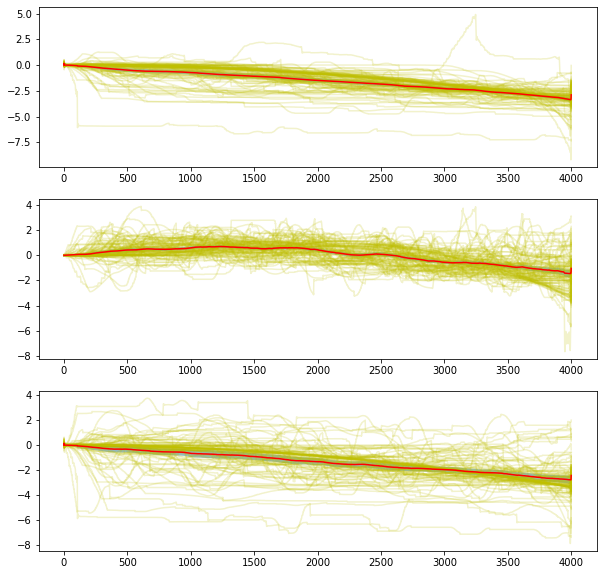

In [52]:
exer = 12
f, (ax,ay,az) = plt.subplots(3,1,figsize = (10,10))

for person in trajectory_dct_rotate:
    if exer in trajectory_dct_rotate[person]:
        ax.plot(trajectory_dct_rotate[person][exer][:,0], c = 'y', alpha = 0.2)
        ay.plot(trajectory_dct_rotate[person][exer][:,1], c = 'y', alpha = 0.2)
        az.plot(trajectory_dct_rotate[person][exer][:,2], c = 'y', alpha = 0.2)
ax.plot(np.arange(4000), mean_per_exercise[exer][:,0], c = 'r')
# ax.plot(trajectory_dct_rotate['43'][exer][:,0], c = 'y')
ax.fill_between(np.arange(4000),  (mean_per_exercise[exer] - 2*std_per_exercise[exer])[:,0], 
                                  (mean_per_exercise[exer] + 2*std_per_exercise[exer])[:,0],
                                   alpha = 0.5)

ay.plot(np.arange(4000), mean_per_exercise[exer][:,1], c = 'r')
# ay.plot(trajectory_dct_rotate['43'][exer][:,1], c = 'y')
ay.fill_between(np.arange(4000),  (mean_per_exercise[exer] - 2*std_per_exercise[exer])[:,1], 
                                  (mean_per_exercise[exer] + 2*std_per_exercise[exer])[:,1],
                                   alpha = 0.5)

az.plot(np.arange(4000), mean_per_exercise[exer][:,2], c = 'r')
# az.plot(trajectory_dct_rotate['43'][exer][:,2], c = 'y')
az.fill_between(np.arange(4000),  (mean_per_exercise[exer] - 2*std_per_exercise[exer])[:,2], 
                                  (mean_per_exercise[exer] + 2*std_per_exercise[exer])[:,2],
                                   alpha = 0.5)

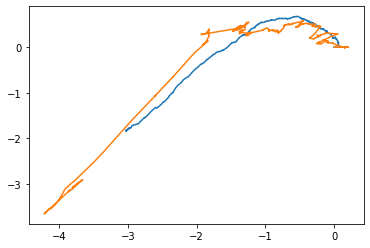

In [53]:
exer = 11

pos = mean_per_exercise[exer]
plt.plot(pos[:,2], pos[:,1])

pos = trajectory_dct_rotate['40'][exer]
plt.plot(pos[:,2], pos[:,1])

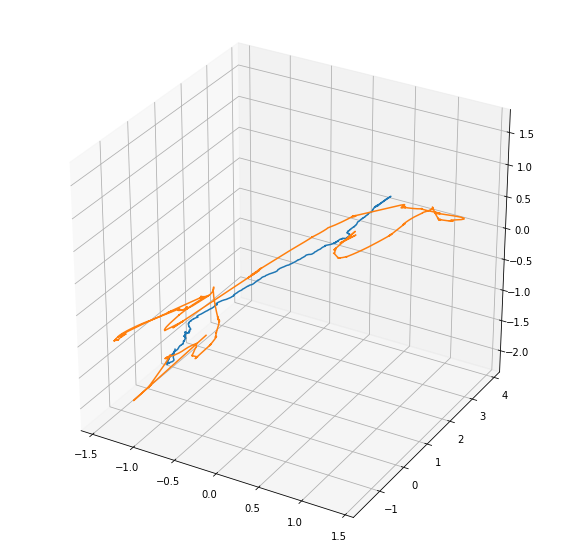

In [347]:
fig = plt.figure(figsize= (10, 10))
start = 0
end = -1
exer = 1
axes = fig.add_subplot(111, projection='3d')
pos = mean_per_exercise[exer]

axes.plot(pos[start:end,2], pos[start:end,1], pos[start:end,0])
pos = trajectory_dct_rotate['50'][exer]

axes.plot(pos[start:end,2], pos[start:end,1], pos[start:end,0])

plt.show()

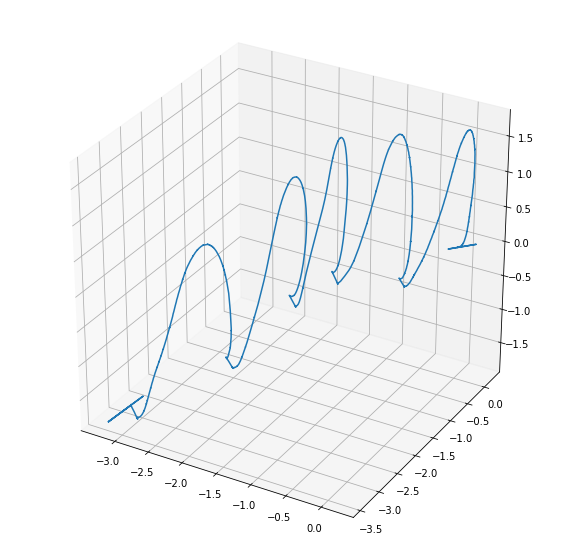

In [12]:
fig = plt.figure(figsize= (10, 10))
start = 0
end = -1
axes = fig.add_subplot(111, projection='3d')
# pos = mean_per_exercise[13]
pos = trajectory_dct_rotate['12'][12]

axes.plot(pos[start:end,2], pos[start:end,0], pos[start:end,1])
plt.show()

NameError: name 'mean_per_exercise' is not defined

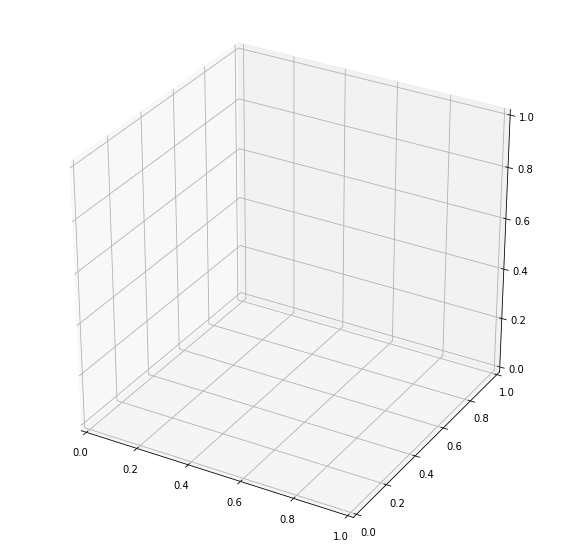

In [13]:
fig = plt.figure(figsize= (10, 10))
start = 0
end = -1
axes = fig.add_subplot(111, projection='3d')
pos = mean_per_exercise[12]
axes.plot(pos[start:end,2], pos[start:end,0], pos[start:end,1])
plt.show()